In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
data, meta = arff.loadarff('desharnais1.1.arff')
df = pd.DataFrame(data)
df.to_csv('desharnais1.1.csv', index = False)

df = pd.read_csv('desharnais1.1.csv')
print(df.head())


   Project  TeamExp  ManagerExp  YearEnd  Length  Effort  Transactions  \
0      1.0      1.0         4.0     85.0    12.0  5152.0         253.0   
1      2.0      0.0         0.0     86.0     4.0  5635.0         197.0   
2      3.0      4.0         4.0     85.0     1.0   805.0          40.0   
3      4.0      0.0         0.0     86.0     5.0  3829.0         200.0   
4      5.0      0.0         0.0     86.0     4.0  2149.0         140.0   

   Entities  PointsNonAdjust  Adjustment  PointsAjust Language  
0      52.0            305.0        34.0        302.0     b'1'  
1     124.0            321.0        33.0        315.0     b'1'  
2      60.0            100.0        18.0         83.0     b'1'  
3     119.0            319.0        30.0        303.0     b'1'  
4      94.0            234.0        24.0        208.0     b'1'  


# 1 Conversion to Numerical Data

Process the 'Language' column by removing the character b' and converting it to float.

In [3]:
print("\n Conversion to Numerical Data")
df['Language'] = df['Language'].str.replace("b'", "").str.replace("'", "").astype(float)

print("\n Data types of columns::")
print(df.dtypes)
print("\nThe data after conversion to numeric format:")
print(df.head())


 Conversion to Numerical Data

 Data types of columns::
Project            float64
TeamExp            float64
ManagerExp         float64
YearEnd            float64
Length             float64
Effort             float64
Transactions       float64
Entities           float64
PointsNonAdjust    float64
Adjustment         float64
PointsAjust        float64
Language           float64
dtype: object

The data after conversion to numeric format:
   Project  TeamExp  ManagerExp  YearEnd  Length  Effort  Transactions  \
0      1.0      1.0         4.0     85.0    12.0  5152.0         253.0   
1      2.0      0.0         0.0     86.0     4.0  5635.0         197.0   
2      3.0      4.0         4.0     85.0     1.0   805.0          40.0   
3      4.0      0.0         0.0     86.0     5.0  3829.0         200.0   
4      5.0      0.0         0.0     86.0     4.0  2149.0         140.0   

   Entities  PointsNonAdjust  Adjustment  PointsAjust  Language  
0      52.0            305.0        34.0        

# 2 Sequential conversion and time indexing

Convert the '**YearEnd**' column to datetime format and use it as the index to support time series analysis.

In [4]:
print(df['YearEnd'].value_counts().sort_index())

print("\n=== Sequential conversion and time indexing ===")
df['YearEnd'] = pd.to_numeric(df['YearEnd'], errors='coerce')
df['YearEnd'] = df['YearEnd'].apply(lambda x: x + 1900 if 0 <= x <= 99 else x).astype('Int64')
df['Date'] = pd.to_datetime(df['YearEnd'].astype(str) + '-12-31', format='%Y-%m-%d', errors='coerce')

df = df.sort_values('Date')
df = df.set_index('Date')

print("The first 5 rows of the newly created 'Date' column:")
print(df.index[:5])

YearEnd
82.0     1
83.0     3
84.0     6
85.0    22
86.0    28
87.0    16
88.0     5
Name: count, dtype: int64

=== Sequential conversion and time indexing ===
The first 5 rows of the newly created 'Date' column:
DatetimeIndex(['1982-12-31', '1983-12-31', '1983-12-31', '1983-12-31',
               '1984-12-31'],
              dtype='datetime64[ns]', name='Date', freq=None)


# 3 Missing Data Processing

Check and handle NaN values to ensure data completeness

If there are missing values, fill the missing values in numeric columns with the mean of each column

In [5]:
print("\nMissing Data Processing")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values")
else:
    print("Have missing values")
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    numeric_columns = [col for col in numeric_columns if col != 'YearEnd']
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())


Missing Data Processing
No missing values


### Handling negative values in TeamExp and ManagerExp

In [6]:
print("\nHandling negative values in TeamExp and ManagerExp:")
df['TeamExp'] = df['TeamExp'].replace(-1, 0)
df['ManagerExp'] = df['ManagerExp'].replace(-1, 0)
print("Replaced -1 with 0 in TeamExp and ManagerExp.")


Handling negative values in TeamExp and ManagerExp:
Replaced -1 with 0 in TeamExp and ManagerExp.


# 4 Handling Outliers (Value Capping)

Mitigate the impact of outliers by capping them within an acceptable range based on the IQR (Interquartile Range)

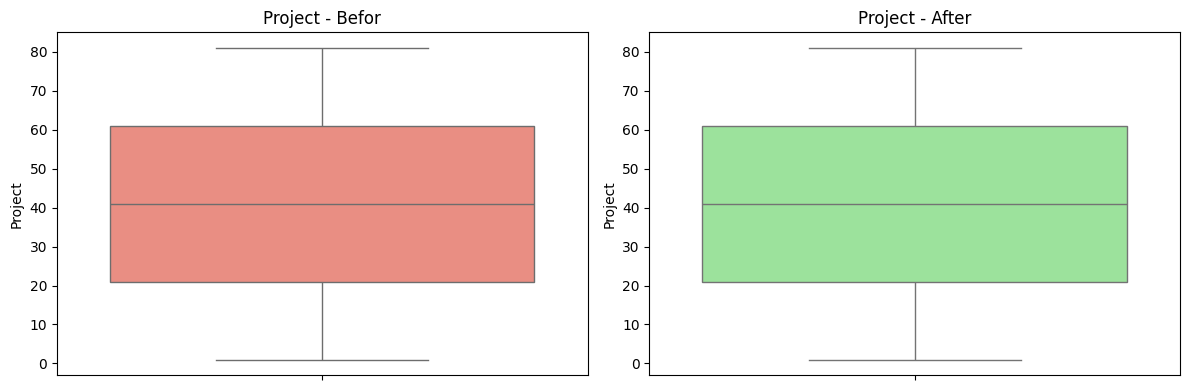

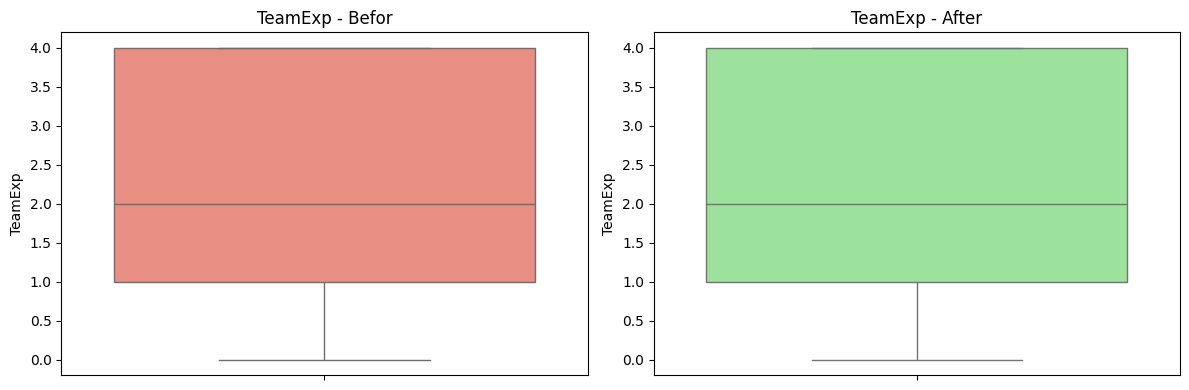

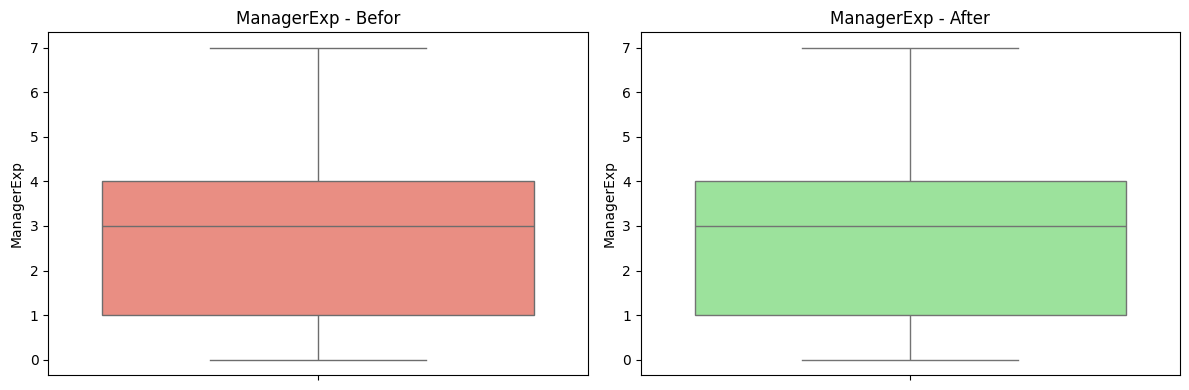

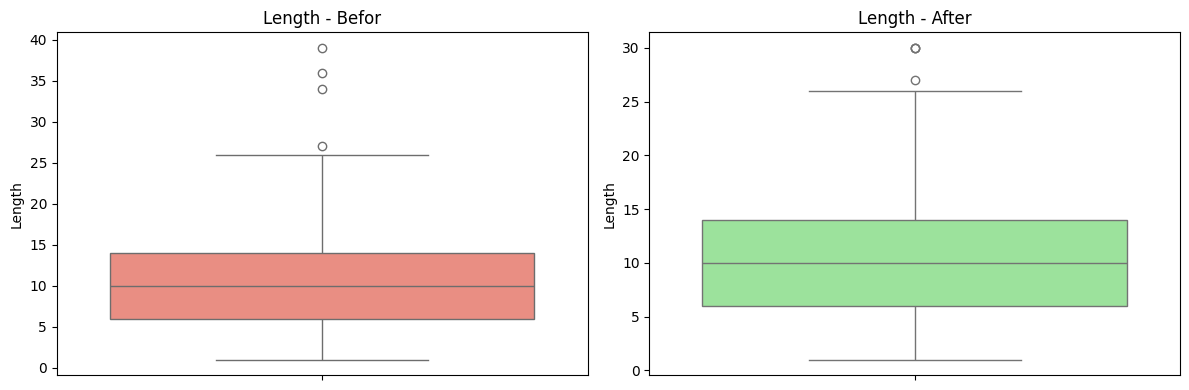

Column Length: Capped 3 outlier(s) using IQR factor of 2.0.


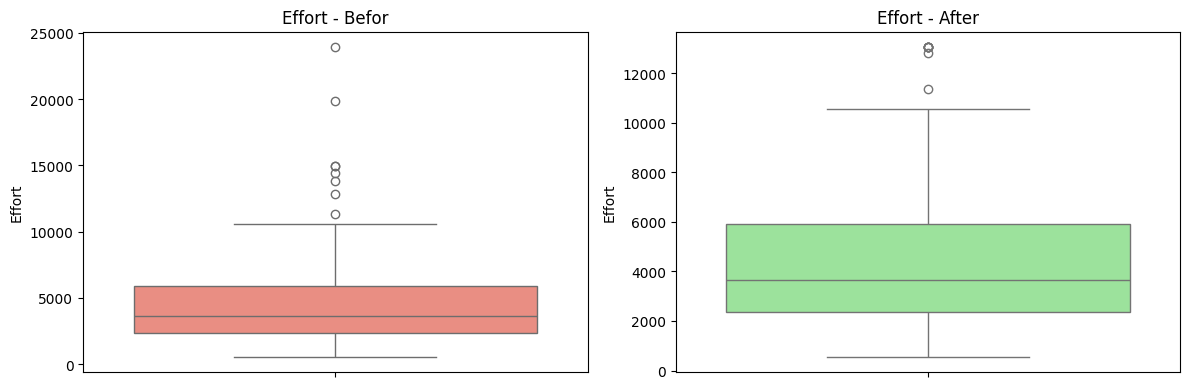

Column Effort: Capped 6 outlier(s) using IQR factor of 2.0.


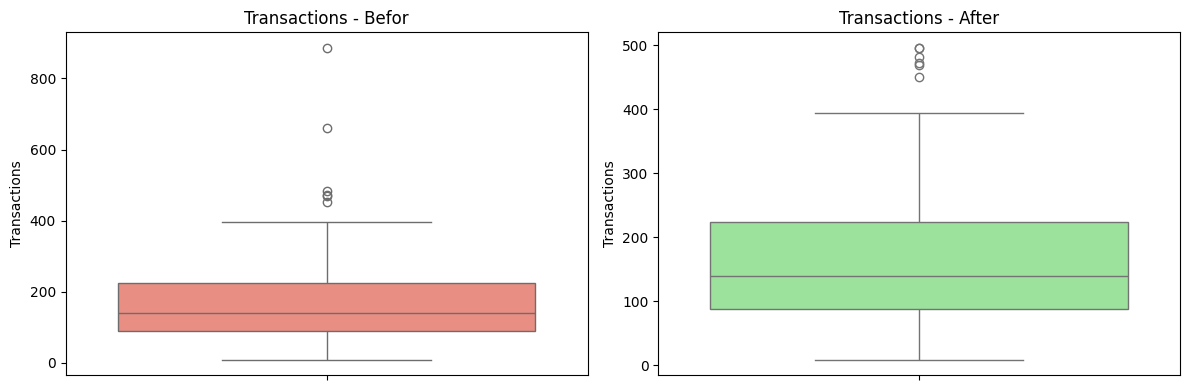

Column Transactions: Capped 2 outlier(s) using IQR factor of 2.0.


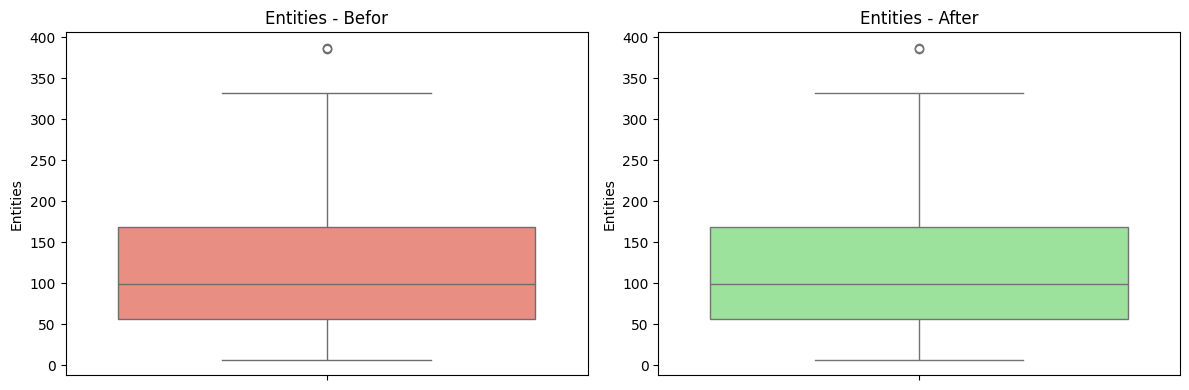

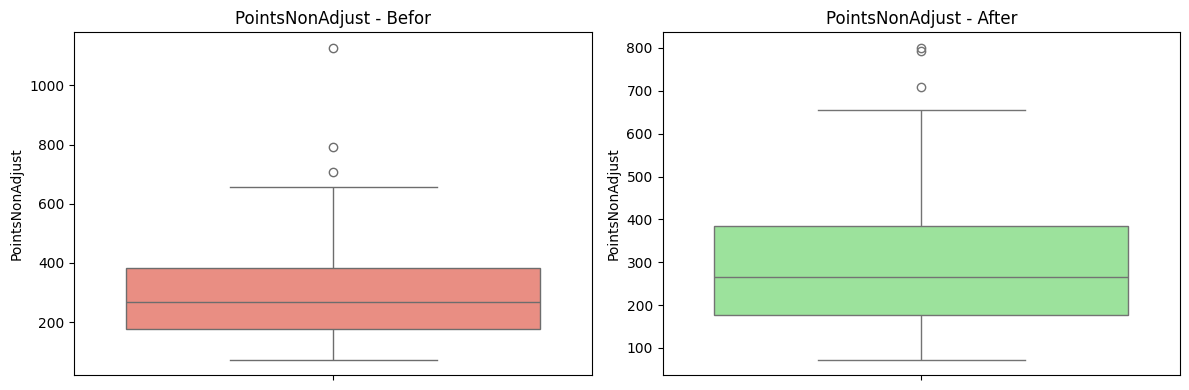

Column PointsNonAdjust: Capped 1 outlier(s) using IQR factor of 2.0.


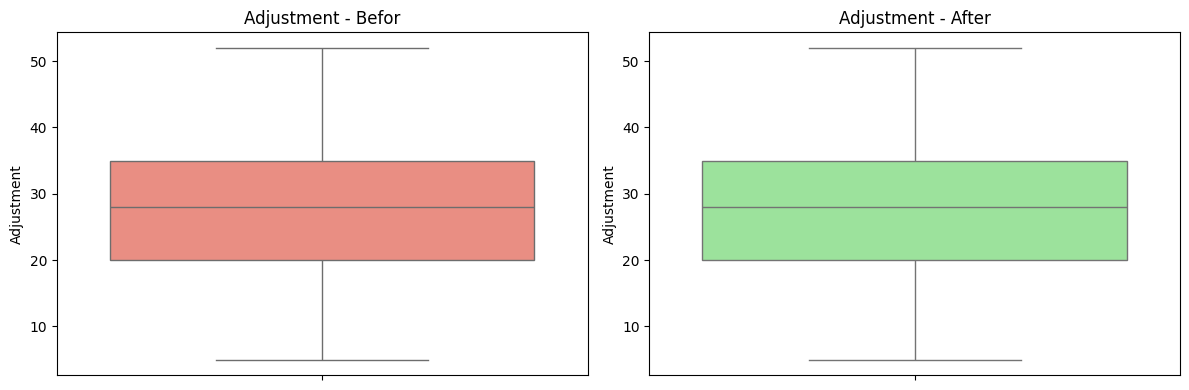

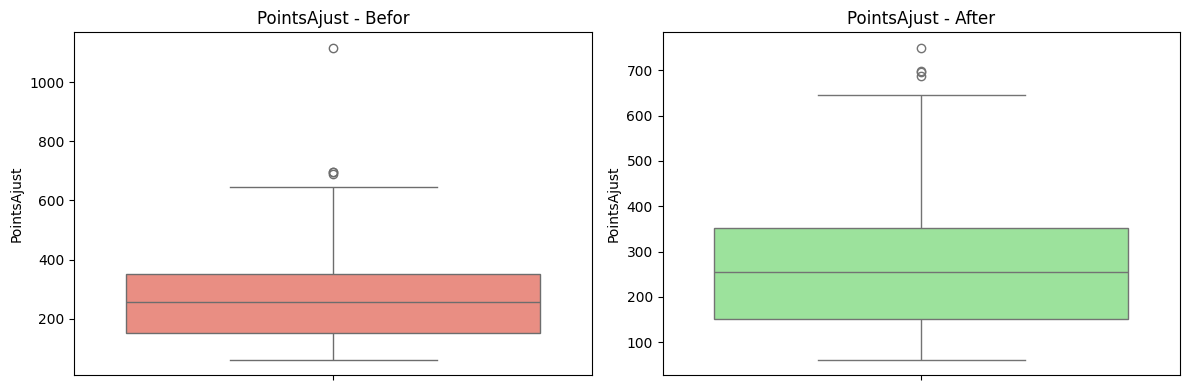

Column PointsAjust: Capped 1 outlier(s) using IQR factor of 2.0.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df_before_outlier = df.copy()

def cap_outliers(df, column, iqr_factor=2.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return outliers_count

columns_to_check = [col for col in df.select_dtypes(include=[np.number]).columns 
                    if col not in ['YearEnd', 'Language']]

for col in columns_to_check:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(y=df_before_outlier[col], ax=axes[0], color='salmon')
    axes[0].set_title(f"{col} - Befor")

    outliers_count = cap_outliers(df, col, iqr_factor=2.0)

    sns.boxplot(y=df[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f"{col} - After")

    plt.tight_layout()
    plt.show()

    if outliers_count > 0:
        print(f"Column {col}: Capped {outliers_count} outlier(s) using IQR factor of 2.0.")


# 5 Visualize Data for Correlation Analysis


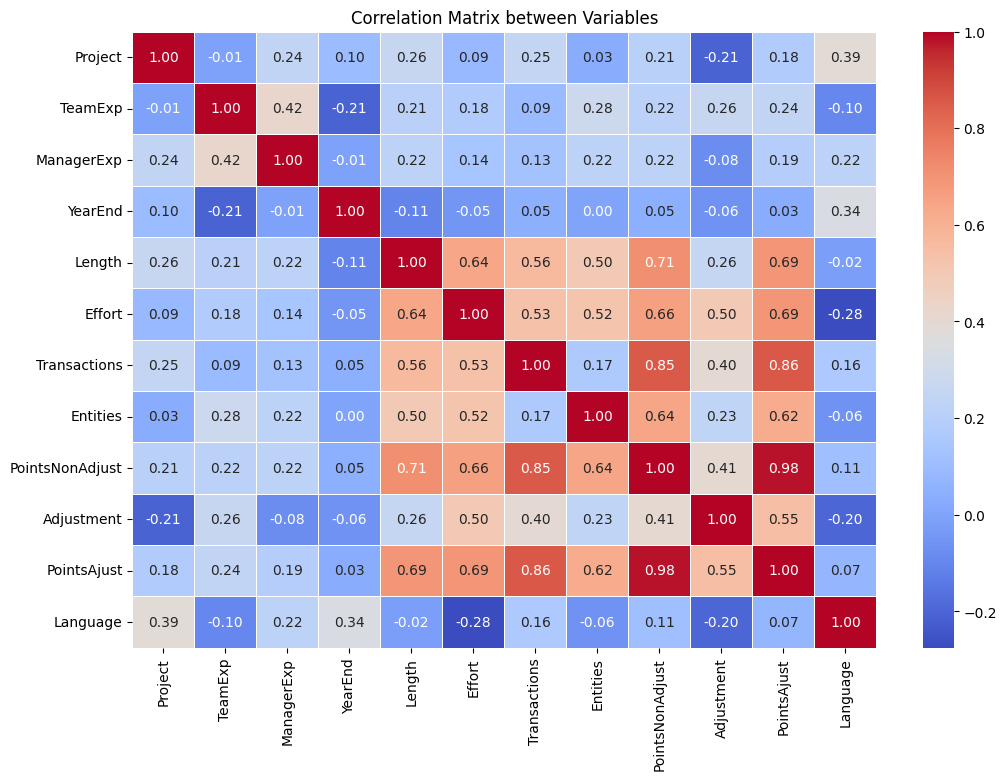

In [11]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix between Variables')
plt.show()


## Correlation with Effort	
- **Length**: 0.64	Strong 
- **PointsNonAdjust**: 0.66 Strong 
- **PointsAdjust**: 0.69 Very strong
- **Transactions**: 0.53 Moderate 
- **Entities**: 0.52 Moderate 
- **Adjustment**: 0.50	Moderate 
- **Language**: -0.28 Slight negative

## High Correlation Between Input Variables (Multicollinearity)

- **PointsNonAdjust** ↔ Transactions: 0.85
- **PointsNonAdjust** ↔ PointsAdjust: 0.98
- **Transactions** ↔ PointsAdjust: 0.86
- **Entities** ↔ PointsAdjust: 0.62
- **PointsNonAdjust** ↔ Entities: 0.64

Keep PointsAjust, drop PointsNonAdjust, Transactions.



In [12]:
df = df.drop(columns=['PointsNonAdjust', 'Transactions'])

# 6. Data Splitting

The dataset is split into training and testing sets using an 80/20 ratio, with 'Effort' as the target variable. Random state is set for reproducibility.

In [15]:
print("\nData Splitting (Partitioning)")
X = df.drop(columns=['Effort', 'Project', 'YearEnd'])  
y = df['Effort']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total number of samples: {len(df)}")
print(f"- Training samples (X_train): {len(X_train)}")
print(f"- Testing samples (X_test): {len(X_test)}")


Data Splitting (Partitioning)
Total number of samples: 81
- Training samples (X_train): 64
- Testing samples (X_test): 17


# 7. Data Standardization

Feature values were standardized using StandardScaler to ensure zero mean and unit variance. This helps improve the performance and convergence speed of many machine learning models.

In [18]:
print("\nData Standardization (StandardScaler)")
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nStatistics before standardization (X_train):")
print(X_train.describe().T[['mean', 'std']])

print("\nStatistics after standardization (X_train_scaled):")
print(X_train_scaled_df.describe().T[['mean', 'std']])



Data Standardization (StandardScaler)

Statistics before standardization (X_train):
                   mean         std
TeamExp        2.234375    1.330261
ManagerExp     2.687500    1.435104
Length        11.500000    6.794022
Entities     118.328125   80.507134
Adjustment    27.218750   10.924661
PointsAjust  286.843750  176.140206
Language       1.609375    0.726312

Statistics after standardization (X_train_scaled):
                     mean       std
TeamExp     -6.938894e-18  1.007905
ManagerExp   6.938894e-18  1.007905
Length       0.000000e+00  1.007905
Entities     0.000000e+00  1.007905
Adjustment  -1.387779e-17  1.007905
PointsAjust  2.775558e-17  1.007905
Language    -2.081668e-17  1.007905


# 8. Inverse Transformation

Inverse transformation is applied to return the standardized data to its original scale. This step is useful for interpretation and comparison with the original dataset.

In [21]:
print("\nInverse Transformation")

X_train_original = scaler_X.inverse_transform(X_train_scaled)
y_train_original = scaler_y.inverse_transform(y_train_scaled)

X_train_original_df = pd.DataFrame(X_train_original, columns=X_train.columns, index=X_train.index)

print("\n=== X_train data after inverse transformation (original scale) ===")
print(pd.DataFrame(X_train_original, columns=X_train.columns).head())

print("\n=== y_train target after inverse transformation ===")
print(y_train_original[:5].flatten())




Inverse Transformation

=== X_train data after inverse transformation (original scale) ===
   TeamExp  ManagerExp  Length  Entities  Adjustment  PointsAjust  Language
0      2.0         4.0    11.0      88.0        28.0        351.0       3.0
1      4.0         2.0     5.0      34.0        29.0         86.0       1.0
2      4.0         7.0    13.0      74.0        14.0        113.0       1.0
3      1.0         1.0     3.0      72.0        19.0         88.0       1.0
4      3.0         4.0    10.0      57.0         9.0        117.0       2.0

=== y_train target after inverse transformation ===
[1435.  840. 1603. 2282. 1155.]


In [ ]:
df.to_csv("desharnais_processed.csv", index=True)